In [39]:
from pylab import *
import numpy as np
from scipy.ndimage import filters
import scipy
import matplotlib.pylab as pyp
from PIL import Image
import transform
import imgutil
import cv2
%matplotlib inline

## Harris Corner Detection
Commonly, Harris corner detector algorithm can be divided into five steps.

1. Color to grayscale

2. Spatial derivative calculation

3. Structure tensor setup

4. Harris response calculation

5. Non-maximum suppression

## Color to grayscale
If we use Harris corner detector in a color image, the first step is to convert it into a grayscale image, which will enhance the processing speed.

<class 'numpy.ndarray'> (4032, 3024)


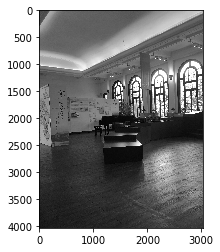

In [40]:
img1 = cv2.imread('2/IMG_2568.JPG', 0)
imshow(img1, cmap='gray')
print (type(img1), img1.shape)

## Spatial derivative calculation & Structure tensor setup

Consider taking an image patch over the area (x,y) and shifting it by (Δx, Δy). The sum of squared differences (SSD) between these two patches, denoted f, is given by:

<img style="float: left;" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/6fc292c785c346ab609ec4dad912f138a3b045ea" width="30%"><br><br>

which can be written in matrix form:

<img style="float: left;" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/38ba7cc61ac4f4bbf25af309c7e3fd6cc78b71d6" width="30%"><br><br><br>

where M is the structure tensor,

<img style="float: left;" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/a617dda21e306dbfbdb7a186b1c203e3f3443867" width="50%">

## Harris response calculation
In this step, we will compute the smallest eigenvalue of the structure tensor with following approximation equation.

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/54a41a283f555687c19e9e724265bdeadb1a563a">

Another common used Harris response calculation is shown as below,

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d2b2a1543d99a75cce4c71bdaff196f769f0b30c">

where k is an empirically determined constant (0.04<k<0.06) .

In [41]:
def HarrisCornerDetector(img, sigma=3):
    #win_size is the minimum number of pixels seperating the corners and image boundary
    
    # derivatives
    imx = zeros(img.shape)
    imy = zeros(img.shape)
    filters.gaussian_filter(img, (sigma, sigma), (0, 1), imx)
    filters.gaussian_filter(img, (sigma, sigma), (1, 0), imy)
    
    # compute components of the Harris matrix
    Ixx = filters.gaussian_filter(imx*imx,sigma)
    Ixy = filters.gaussian_filter(imx*imy,sigma)
    Iyy = filters.gaussian_filter(imy*imy,sigma)
    
    det = Ixx*Iyy - Ixy**2
    trace = Ixx + Iyy + 1e-10
    #R = det - 0.04*(trace**2)
    R = det / trace
    
    return R

In [42]:
corner_response = HarrisCornerDetector(img1)
print (corner_response.shape)

(4032, 3024)


## Non-maximum suppression
In order to pick up the optimal values to indicate corners, we find the local maxima as corners within the window which is a 3 by 3 filter.

In [43]:
def supression(R, win=5, thres=512):
    h, w = R.shape[0:2]
    
    R[:win, :] = 0
    R[-win:, :] = 0
    R[:, :win] = 0
    R[:, -win:] = 0
    
    # non-maximum suppression in 3x3 regions
    maxH = filters.maximum_filter(R, (win, win))
    R = R * (R == maxH)

    # sort points by strength and find their positions
    sortIdx = np.argsort(R.flatten())[::-1][:thres]
    y = sortIdx // w
    x = sortIdx % w

    # concatenate positions and values
    coords = np.vstack((x, y, R.flatten()[sortIdx])).T

    return coords

In [44]:
coords = supression(corner_response)
print (coords.shape)

(512, 3)


In [45]:
def plot_corners(img, coords): #Plots Harris corners on graph
    fig = figure(figsize=(15, 8))
    gray()
    imshow(img)
    plot(coords[:, 0], coords[:, 1], 'r*', markersize=5)
    axis('off')
    show()

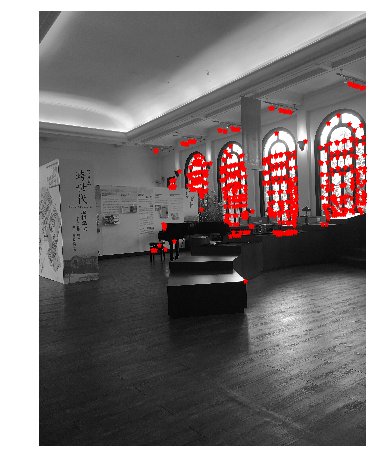

In [46]:
plot_corners(img1, coords)

In [60]:
def gen_descriptors(img, coords, win=3): #return pixel value
    descriptors = []
    for c in coords:
        x, y = int(c[1]), int(c[0])
        patch = img[x-win:x+win+1, y-win:y+win+1].flatten()
        # normalize the descriptor
        patch = (patch - patch.mean()) / patch.std()
        descriptors.append(patch)
    return np.array(descriptors)

In [61]:
descriptors = gen_descriptors(img1, coords)
print (descriptors.shape)

(512, 49)


In [48]:
descriptors = gen_descriptors(img1, coords)
print (descriptors.shape)

(512, 49)


In [49]:
def match(d1, d2):
    n = len(d1)
    
    dists = scipy.spatial.distance.cdist(d1, d2)
    print ('dists', dists.shape)
    sort_idx = np.argsort(dists, 1)

    # find best indices and their distances
    best_idx = sort_idx[:, 0]
    best_distance = dists[np.r_[0: n], best_idx]

    # find second best indices and their distances
    second_best_idx = sort_idx[:, 1]
    second_best_distance = dists[np.r_[0:n], second_best_idx]

    # find the average of the second best distance
    mean = second_best_distance.mean()
    ratio = best_distance / mean

    # find the indices of the bestMatches for each descriptor
    desc1_match = np.argwhere(ratio < 0.5)
    desc2_match = best_idx[desc1_match]

    # put the matches in a single array and return as type int
    matches = np.hstack([desc1_match, desc2_match])
    
    return matches.astype(int)

In [50]:
def match2(d1, d2, thres=0.5, method='ncc'):
    # feature dim
    n = len(d1[0])
    
    if method == 'ncc': # normalized cross corelation
        d = -np.ones((len(d1), len(d2)))
        for i in range(len(d1)):
            for j in range(len(d2)):
                dist1 = (d1[i] - np.mean(d1[i])) / np.std(d1[i])
                dist2 = (d2[j] - np.mean(d2[j])) / np.std(d2[j])
                ncc_value = np.sum(dist1 * dist2) / (n-1)
                if ncc_value > thres:
                    d[i, j] = ncc_value

        ndx = np.argsort(-d)
        matchscores = ndx[:, 0]
        return matchscores # matched coords
    
    elif method == 'ed': # Euclidean Distance
        min_dist, max_dist = 100, 0
        distance = np.zeros((len(d1), len(d2)))
        for i in range(len(d1)):
            for j in range(len(d2)):
                dist = np.linalg.norm(d1[i]-d2[j])
                min_dist = min(min_dist, dist)
                max_dist = max(max_dist, dist)
                distance[i, j] = dist
        
        sort_dist = np.argsort(distance)[:, 0]
        min_dist = max(min_dist, thres)
        good_match = []
        for i, j in enumerate(sort_dist):
            if distance[i, j] < min_dist/thres:
                good_match.append([i, j])

        return np.array(good_match)

In [51]:
def match_two_side(d1, d2, thres=0.5): #Same as above, two sided symmetric version
    
    matches_12 = match(d1, d2)
    matches_21 = match(d2, d1)
    
    ndx_12 = np.where(matches_12 >= 0)[0]
    
    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    
    return matches_12

In [52]:
def appendimages(im1, im2): #the appended images displayed side by side for image mapping
    
    # select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = concatenate((im1,zeros((rows2-rows1,im1.shape[1]))),axis=1)
    elif rows1 > rows2:
        im2 = concatenate((im2,zeros((rows1-rows2,im2.shape[1]))),axis=1)
    
    
    return concatenate((im2, im1), axis=1)

(4032, 3024)
512 coords
512 descriptor


<Figure size 1440x720 with 0 Axes>

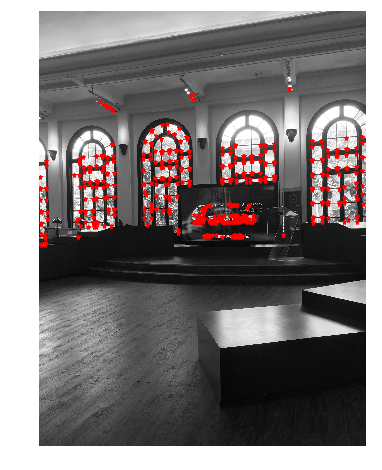

In [53]:
#img2 = np.array(Image.open('2/IMG_2567.JPG').convert("L"))
img2 = cv2.imread('2/IMG_2569.JPG', 0)
corner_response2 = HarrisCornerDetector(img2)
print (corner_response2.shape)
coords2 = supression(corner_response2)
print (len(coords2), 'coords')
descriptors2 = gen_descriptors(img2, coords2)
print (len(descriptors2), 'descriptor')
figure(figsize=(20, 10))
plot_corners(img2, coords2)

In [54]:
print (len(descriptors), len(descriptors2))

512 512


dists (512, 512)
43 matches


(-0.5, 6047.5, 4031.5, -0.5)

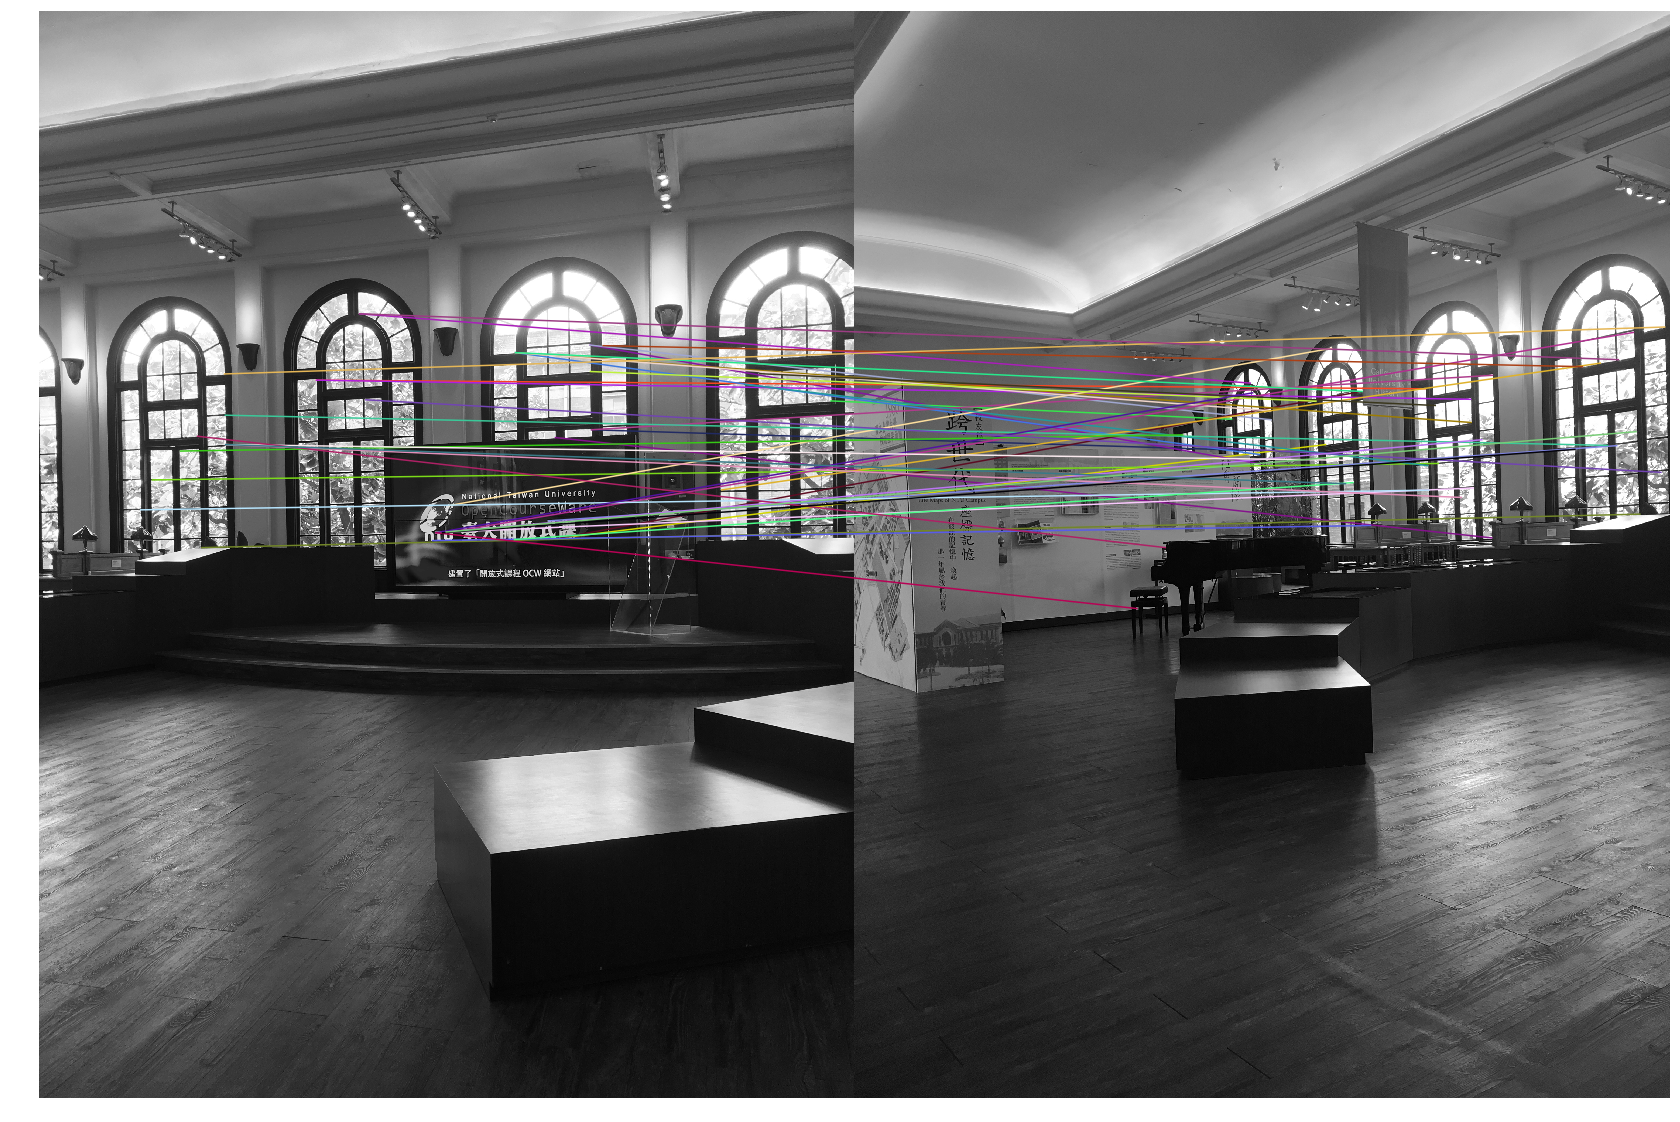

In [55]:
matches = match(descriptors, descriptors2)
#matches = match2(descriptors, descriptors2, method='ed')
print (len(matches), 'matches')
im3 = appendimages(img1,img2)
#im3 = np.hstack((im3,im3))
figure(figsize=(30, 20))
imshow(im3)
cols1 = img1.shape[1]
for i, m in enumerate(matches):
    y, x = coords[m[0]], coords2[m[1]]
    plot([x[0], y[0]+cols1], [x[1], y[1]], 'c', c=[np.random.random(), np.random.random(), np.random.random()])
    #plot([x[1], y[1]], [x[0], y[0]+cols1], 'c', c=[np.random.random(), np.random.random(), np.random.random()])
axis('off')